In [1]:
import sys
from os import listdir, getcwd
from os.path import isfile, join
import pandas as pd
import email


def main():
    user_input_path = sys.argv[1]

    directories = [
            'easy_ham',
            'easy_ham_2',
            'hard_ham',
            'spam',
            'spam_2'
            ]

    msgs = []
    file_name = []
    label = []
    for d in directories:
        #mypath = user_input_path + '/' + d + '/'
        mypath = getcwd() + '/SpamAssassinMessages/' + d + '/'
        myfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

        for file in myfiles:
            with open(mypath + file, encoding='latin1') as f:
                msg = email.message_from_file(f)
                for part in msg.walk():
                    if "spam" in d:
                        label.append(1)
                    else:
                        label.append(0)
                    file_name.append(file)
                    payload = part.get_payload()
                    msgs.append(payload)

    df = pd.DataFrame({"filename":file_name, "is_spam":label})
    df['messages'] = msgs
           
    return df, msgs

#main()
df, msgs = main()

In [2]:
df.sample(10)

,filename,is_spam,messages
10076,00832.0d3ac1ac07d86394e068a3b84782ca4c,1,<html>\n<body bgcolor=#FFFFFF link=blue vlink=...
4191,1366.200cc41f250f28147c5db07ea933f26a,0,Any plans for rolling Nessus RPMs for RH8? Mi...
261,00224.937d82e92fbb4a21cc11cc49310eff39,0,"While I was playing with the past issues, it a..."
1098,00950.552f3425d82204ce19d468127085b7d9,0,\n\ncwg-dated-1030817858.a49b7e@DeepEddy.Com s...
6515,00969.06ff0d8ef44307c5808b526dc72c3f68,0,\nBegeman's _Manufacturing Processes_\ntalks a...
10442,01125.46ca779f86e1dd0a03c3ffc67b57f55e,1,¡±101½ÌÓýÍø¡°ÍÆ¼ö¡¶Ä§¹íÓ¢Óï¡·\n¡±ÖÐ¹ú½ÌÓýÍø¡°Í...
7162,00139.8164b7e486cc17d8f2c921f99e05ed10,0,"[[Content-Type, Content-Transfer-Encoding], [C..."
6852,01291.54c5040c1d26a7c505404e1038a5287c,0,Thanks Dan. And the changes were very clever. ...
7283,00208.818667cfa44cba08793363ad0c1d3199,0,"Hi XFS developers,\nWhen studying xfs code(2.4..."
6387,00849.46a55512abd378c6158e43b88acf3ed0,0,"\nIn a message dated 7/23/2002 8:51:00 PM, joe..."


In [3]:
df.shape[0]

10805

- 10805 instead of 9353 means that I did address the multipart messages.

### Watching out for entry index 1040

In [4]:
df[df["filename"].str.contains('00947')]

,filename,is_spam,messages
1088,00947.488310e3c7ba27ec9d99d390007b8c53,0,"[[Content-Type], [Content-Type]]"
1089,00947.488310e3c7ba27ec9d99d390007b8c53,0,> From: Anders Eriksson <aeriksson@fastmail.f...
1090,00947.488310e3c7ba27ec9d99d390007b8c53,0,-----BEGIN PGP SIGNATURE-----\nVersion: GnuPG ...
6493,00947.5983cb8fa9a4c2a27cb6eca03e0be56d,0,\nIt took me a week to get down to this;\nThe ...
10210,00947.e4d80402e902f1ea42cfc539bb279afd,1,"<HR>\n<html>\n<div bgcolor=3D""#FFFFCC"">\n\n <..."


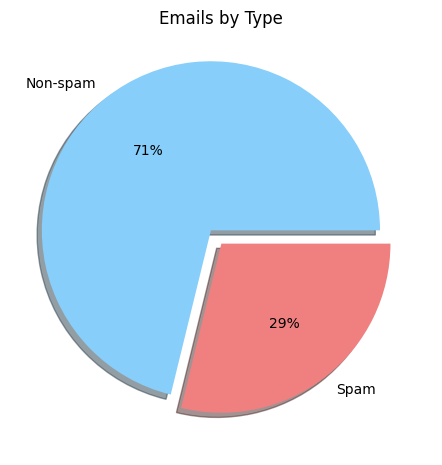

In [5]:
import matplotlib.pyplot as plt
# Plot of Spam Emails
pie_labels = 'Non-spam', 'Spam'
colors = ['lightskyblue', 'lightcoral']
explode = (0.1, 0)
plt.figure(figsize=(12, 12))
plt.subplot(121)
df['is_spam'].value_counts(dropna=False).plot.pie(
    autopct='%0.0f%%', labels=pie_labels, colors=colors, explode=explode, shadow=True)

plt.title("Emails by Type")
plt.ylabel("")
plt.show()

# Vectorizing
### Function to Normalize Text 

In [6]:
import nltk
import re

def normalize_text_func(text):
    stop_words = nltk.corpus.stopwords.words('english')

    # make all special characters lowercase and remove them
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text, re.I | re.A)
    text = text.lower()
    text = text.strip()

    # tokenize document
    tokens = nltk.word_tokenize(text)

    # filter out stop words
    filtered_tokens = [token for token in tokens
                       if token not in stop_words]

    # Remove numbers
    filtered_tokens = [token for token in filtered_tokens
                       if not token.isdigit()]

    # Remove short tokens
    filtered_tokens = [token for token in filtered_tokens
                       if len(token) > 2]

    # re-create a normalized document
    text = ' '.join(filtered_tokens)
    return text

### Convert Normalized Text into Matrix of TF-IDF Features
- ngram_range=(1,3):    pull in all 3 unigrams, bigrams and trigrams
- min_df=5:             ignore terms that appear in less than 5 emails
- max_df=0.8:           ignore terms that appear more than 80% of each email
- stopwords:            english stopwords

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np

normalize_text = np.vectorize(normalize_text_func)
normalized_text = normalize_text(df['messages'].astype('str'))

vectorizer = TfidfVectorizer()#ngram_range=(1,3), 
                             #min_df=5, max_df=0.8, 
                             #stop_words='english')
# tf_matrix = vectorizer.fit_transform(df['messages'].astype('str'))
tf_matrix = vectorizer.fit_transform(str(i) for i in normalized_text)

In [8]:
df['messages'].astype('str')

0            Date:        Wed, 21 Aug 2002 10:54:46 -05...
1        Martin A posted:\nTassos Papadopoulos, the Gre...
2        Man Threatens Explosion In Moscow \n\nThursday...
3        Klez: The Virus That Won't Die\n \nAlready the...
4        >  in adding cream to spaghetti carbonara, whi...
                               ...                        
10800    <html>\n<head>\n<title>Preferred Non-Smoker Ra...
10801    Dear Subscriber,\n\nIf I could show you a way ...
10802    ****Mid-Summer Customer Appreciation SALE!****...
10803    ATTN:SIR/MADAN      \n\n                      ...
10804    mv 00001.317e78fa8ee2f54cd4890fdc09ba8176 0000...
Name: messages, Length: 10805, dtype: object

In [9]:
print(tf_matrix[1].toarray())

[[0. 0. 0. ... 0. 0. 0.]]


In [10]:
tf_matrix.shape[0]

10805

# Clustering
### Finding Optimal K

100%|██████████| 12/12 [01:23<00:00,  6.99s/it]


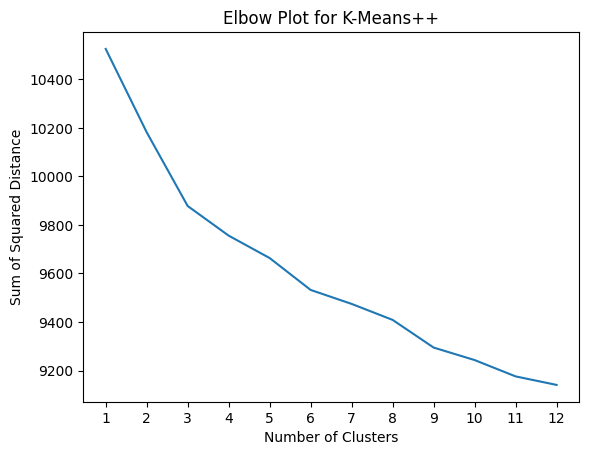

In [11]:
from tqdm import tqdm
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

scores = []
nK = 13     # initial guess: clusters

for k in tqdm(range(1, nK)):
    kmeans = KMeans( init='k-means++', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    kmeans.fit(tf_matrix) ###########

    scores.append(kmeans.inertia_)

plt.plot(range(1, nK), scores)
plt.xticks(range(1, nK))
plt.title("Elbow Plot for K-Means++")
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Distance")
plt.show()

- We have strong evidence that the best number of clusters is 3, however we will visualize further with SilhouetteVisualizer.

100%|██████████| 6/6 [01:18<00:00, 13.17s/it]


Average Silhouette scores for k clusters:
2 : 0.025
3 : 0.040
4 : 0.043
5 : 0.046
6 : 0.043
7 : 0.046
maximum silhouette score for 5 clusters:  0.046


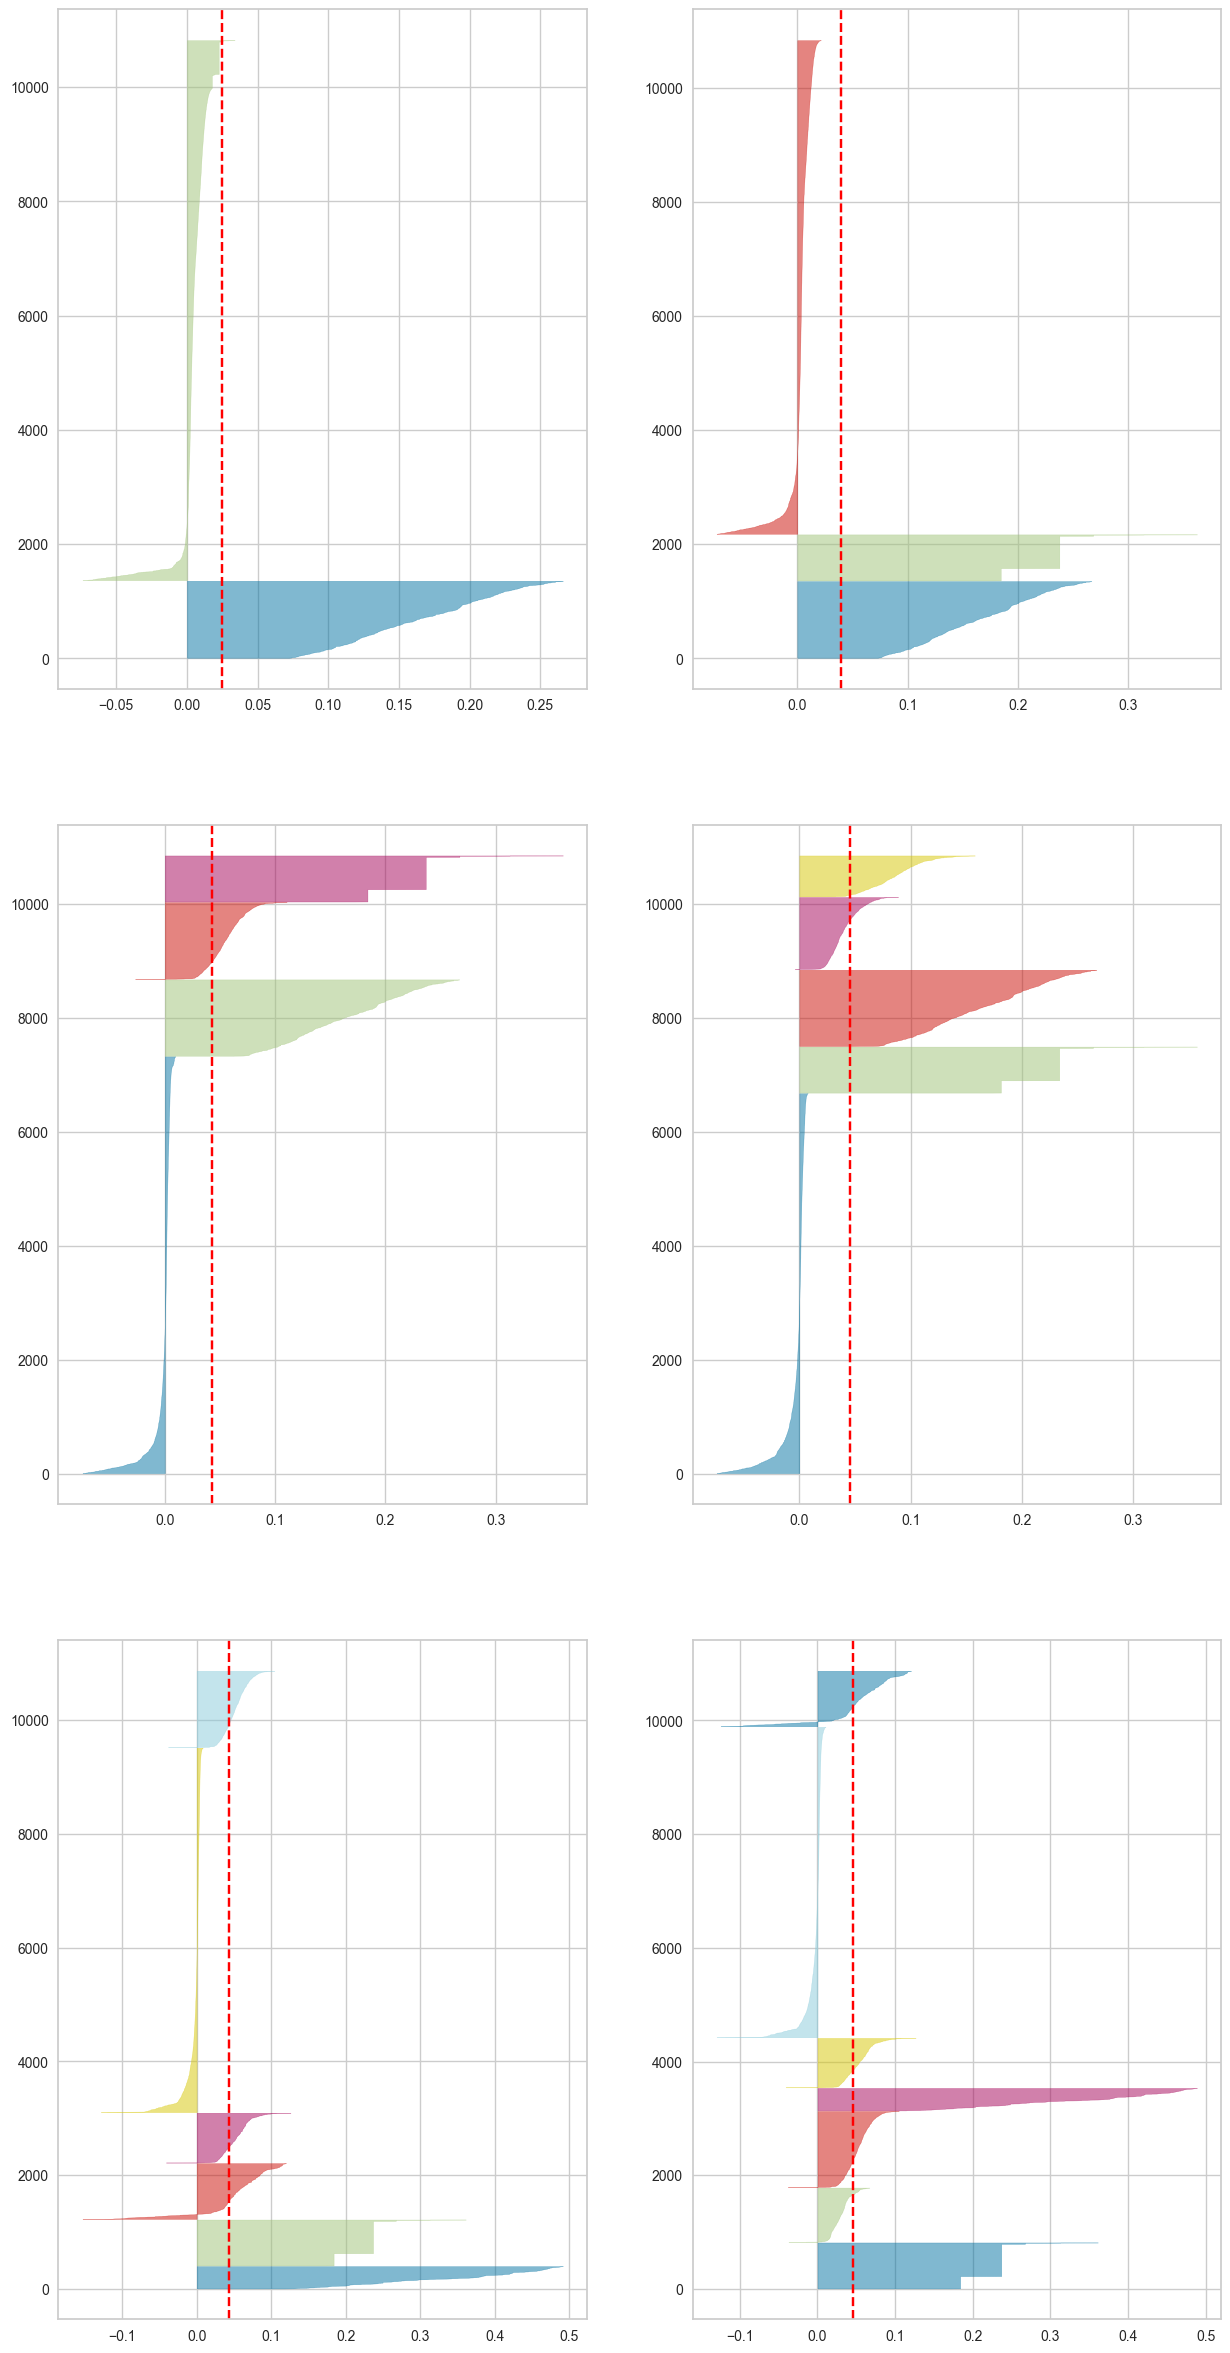

In [12]:
import numpy as np
from yellowbrick.cluster import SilhouetteVisualizer

nK = 8     # initial guess: clusters
RNDN = 42   # random state

# silhouette score plots with Yellowbrick
dict_score = dict()
fig, ax = plt.subplots(int(np.ceil(nK/2)-1), 2, figsize=(15,30))

for i in tqdm(range(2, nK)):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=RNDN)
    
    q, mod = divmod(i, 2)
    vis = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod], is_fitted=False)
    
    vis.fit(tf_matrix) #############

    dict_score[i] = vis.silhouette_score_


print("Average Silhouette scores for k clusters:")
_ = [print(k,":",f'{v:.3f}') for k,v in dict_score.items()]

K_sil_a3 = max(dict_score, key=dict_score.get)          # optimal clusters
sil_opt_a3 = dict_score[K_sil_a3]                       # optimal (maximal) silhouette score
print("maximum silhouette score for", f'{K_sil_a3:.0f} clusters: ', f'{sil_opt_a3:.3f}')

- We decided to choose the "right" number of clusters based on one, if all clusters are above the average score of the dataset, determined by the red dotted line, and two, all clusters have uniform sizes. However, 6 clusters seem to have the more uniform sized clusters, except the one that looks like an L, and all clusters are above the red dotted line.

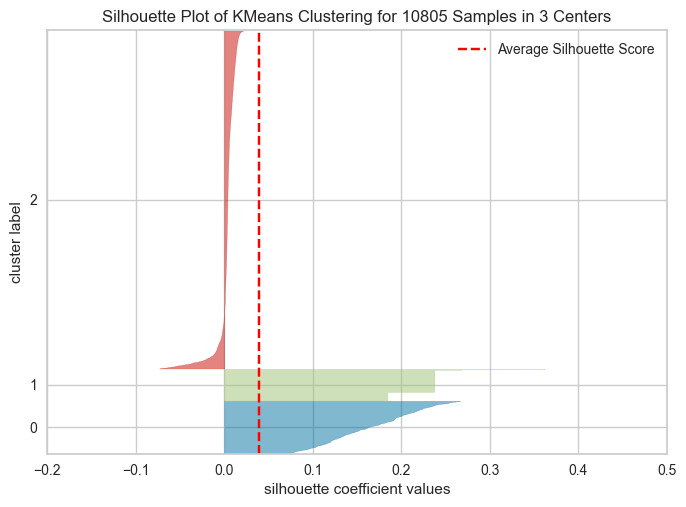

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 10805 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [13]:
from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(n_clusters=3, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(tf_matrix)    
visualizer.show()        

### Assign which of the 3 clusters that each of the entry indeces belong to

In [14]:
from sklearn.metrics import silhouette_samples

NUM_CLUSTERS = 3
km = KMeans(n_clusters=NUM_CLUSTERS, 
            max_iter=10000, 
            n_init=10, 
            random_state=42).fit(tf_matrix)
df['kmeans_cluster'] = km.labels_

In [15]:
email_clusters = (df[['is_spam', 'kmeans_cluster']]
                  .sort_values(by=['kmeans_cluster'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))
email_clusters = email_clusters.copy(deep=True)

feature_names = vectorizer.get_feature_names_out()
topn_features = 12
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

sample_silhouette_values = silhouette_samples(tf_matrix, km.labels_)

# get key features for each cluster
for cluster_num in range(NUM_CLUSTERS):

    cluster_silhouette_values = sample_silhouette_values[km.labels_ == cluster_num]

    key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
    print('CLUSTER #'+str(cluster_num+1), "Average Silhouette Value:", cluster_silhouette_values.mean())
    print('Cluster Size', cluster_silhouette_values.shape[0])
    print('Key Features:', key_features)
    print('-'*80)

CLUSTER #1 Average Silhouette Value: 0.16457198742573478
Cluster Size 1345
Key Features: ['font', '3d', 'width', 'size', 'td', 'color', 'face', 'nbsp', 'height', 'align', 'arial', 'href']
--------------------------------------------------------------------------------
CLUSTER #2 Average Silhouette Value: 0.22440806402376912
Cluster Size 809
Key Features: ['message', 'object', 'email', '0x0000029a37c17cd0', '0x0000029a37c17a00', '0x0000029a38c5a920', '0x0000029a38c5a8f0', '0x0000029a38c58ac0', '0x0000029a37a29ea0', '0x0000029a37c178b0', '0x0000029a37c17a60', '0x0000029a37c17850']
--------------------------------------------------------------------------------
CLUSTER #3 Average Silhouette Value: 0.0029283346303815515
Cluster Size 8651
Key Features: ['com', 'http', 'linux', 'www', 'net', 'list', 'rpm', 'lists', 'date', 'spamassassin', 'url', 'users']
--------------------------------------------------------------------------------


# Naive Bayes Classifier

The below script was tested with all 5 possible supervised methods of Naive Bayes from sklearn, to which CategoricalNB resulted the highest scores for all three accuracy, precision and recall, and it also serves as the starting point for adjusting the classification threshold.

In [16]:
df['messages']

0            Date:        Wed, 21 Aug 2002 10:54:46 -05...
1        Martin A posted:\nTassos Papadopoulos, the Gre...
2        Man Threatens Explosion In Moscow \n\nThursday...
3        Klez: The Virus That Won't Die\n \nAlready the...
4        >  in adding cream to spaghetti carbonara, whi...
                               ...                        
10800    <html>\n<head>\n<title>Preferred Non-Smoker Ra...
10801    Dear Subscriber,\n\nIf I could show you a way ...
10802    ****Mid-Summer Customer Appreciation SALE!****...
10803    ATTN:SIR/MADAN      \n\n                      ...
10804    mv 00001.317e78fa8ee2f54cd4890fdc09ba8176 0000...
Name: messages, Length: 10805, dtype: object

In [17]:
from sklearn.naive_bayes import (BernoulliNB, CategoricalNB, ComplementNB, 
                                 GaussianNB, MultinomialNB)
from sklearn.model_selection import cross_val_score

bernoulli_NB = BernoulliNB()
bernoulli_NB.fit(tf_matrix.toarray(), df['is_spam'])

cross_val_score(
    bernoulli_NB, tf_matrix.toarray(), df['is_spam'],
    cv=5, n_jobs=1, scoring='accuracy')


array([0.8727441 , 0.89819528, 0.85515965, 0.8736696 , 0.66959741])

In [18]:
from sklearn.naive_bayes import (BernoulliNB, CategoricalNB, ComplementNB, 
                                 GaussianNB, MultinomialNB)
from sklearn.model_selection import cross_val_score

categorical_NB = CategoricalNB()
categorical_NB.fit(tf_matrix.toarray(), df['is_spam'])

cross_val_score(
    categorical_NB, tf_matrix.toarray(), df['is_spam'],
    cv=5, n_jobs=1, scoring='accuracy')


c:\Users\dnguy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\dnguy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\dnguy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "c:\Users\dnguy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\Users\dnguy\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 71, in _cached_call
    return getattr(estim

array([0.71217029, 0.71170754, 0.71170754, 0.71170754,        nan])

In [19]:
from sklearn.naive_bayes import (BernoulliNB, CategoricalNB, ComplementNB, 
                                 GaussianNB, MultinomialNB)
from sklearn.model_selection import cross_val_score

complement_NB = ComplementNB()
complement_NB.fit(tf_matrix.toarray(), df['is_spam'])

cross_val_score(
    complement_NB, tf_matrix.toarray(), df['is_spam'],
    cv=5, n_jobs=1, scoring='accuracy')


array([0.91670523, 0.93336418, 0.86626562, 0.92364646, 0.70060157])

In [20]:
from sklearn.naive_bayes import (BernoulliNB, CategoricalNB, ComplementNB, 
                                 GaussianNB, MultinomialNB)
from sklearn.model_selection import cross_val_score

gaussian_NB = GaussianNB()
gaussian_NB.fit(tf_matrix.toarray(), df['is_spam'])

cross_val_score(
    gaussian_NB, tf_matrix.toarray(), df['is_spam'],
    cv=5, n_jobs=1, scoring='accuracy')


array([0.9467839 , 0.94909764, 0.87783434, 0.91300324, 0.80379454])

In [21]:
from sklearn.naive_bayes import (BernoulliNB, CategoricalNB, ComplementNB, 
                                 GaussianNB, MultinomialNB)
from sklearn.model_selection import cross_val_score

multinomial_NB = MultinomialNB()
multinomial_NB.fit(tf_matrix.toarray(), df['is_spam'])

cross_val_score(
    multinomial_NB, tf_matrix.toarray(), df['is_spam'],
    cv=5, n_jobs=1, scoring='accuracy')


array([0.87829708, 0.87875983, 0.84359093, 0.8727441 , 0.71355854])

# Add Clusters Column to tf_matrix

In [22]:
tf_matrix_array = tf_matrix.toarray()
tf_matrix_array_cluster = np.append(
    tf_matrix_array, df['kmeans_cluster'].values.reshape(-1,1), axis=1)

In [23]:
tf_matrix.shape

(10805, 131656)

In [24]:
tf_matrix_array_cluster.shape

(10805, 131657)

### tf_matrix gaussian_NB

In [25]:
from sklearn.metrics import classification_report

gaussian_NB = GaussianNB()
gaussian_NB.fit(tf_matrix.toarray(), df['is_spam'])

threshold = .5
y_preds = (gaussian_NB.predict_proba(tf_matrix.toarray())[:, 1] > threshold).astype('float')
#y_preds = categorical_NB.predict(tf_matrix_test.toarray())

print("Classification Report (Threshold = ", threshold,"):")
print(classification_report(df['is_spam'], y_preds, digits=4))


Classification Report (Threshold =  0.5 ):
              precision    recall  f1-score   support

           0     0.9962    1.0000    0.9981      7691
           1     1.0000    0.9907    0.9953      3114

    accuracy                         0.9973     10805
   macro avg     0.9981    0.9953    0.9967     10805
weighted avg     0.9973    0.9973    0.9973     10805



### tf_matrix_array_cluster gaussian_NB

In [30]:
from sklearn.naive_bayes import (BernoulliNB, CategoricalNB, ComplementNB, 
                                 GaussianNB, MultinomialNB)
from sklearn.metrics import classification_report

gaussian_NB = GaussianNB()
gaussian_NB.fit(tf_matrix_array_cluster, df['is_spam'])

threshold = .5
y_preds = (gaussian_NB.predict_proba(tf_matrix_array_cluster)[:, 1] > threshold).astype('float')
#y_preds = categorical_NB.predict(tf_matrix_test.toarray())

print("Classification Report (Threshold = ", threshold,") (Algorithm = ", gaussian_NB,"):")
print(classification_report(df['is_spam'], y_preds, digits=4))


Classification Report (Threshold =  0.5 ) (Algorithm =  GaussianNB() ):
              precision    recall  f1-score   support

           0     0.9966    1.0000    0.9983      7691
           1     1.0000    0.9917    0.9958      3114

    accuracy                         0.9976     10805
   macro avg     0.9983    0.9958    0.9971     10805
weighted avg     0.9976    0.9976    0.9976     10805



In [34]:
from sklearn.naive_bayes import (BernoulliNB, CategoricalNB, ComplementNB, 
                                 GaussianNB, MultinomialNB)
from sklearn.metrics import classification_report

bernoulli_NB = BernoulliNB()
bernoulli_NB.fit(tf_matrix_array_cluster, df['is_spam'])

threshold = .5
y_preds = (bernoulli_NB.predict_proba(tf_matrix_array_cluster)[:, 1] > threshold).astype('float')
#y_preds = categorical_NB.predict(tf_matrix_test.toarray())

print("Classification Report (Threshold = ", threshold,") (Algorithm = ", bernoulli_NB,"):")
print(classification_report(df['is_spam'], y_preds, digits=4))


Classification Report (Threshold =  0.5 ) (Algorithm =  BernoulliNB() ):
              precision    recall  f1-score   support

           0     0.8730    0.9947    0.9299      7691
           1     0.9799    0.6426    0.7762      3114

    accuracy                         0.8932     10805
   macro avg     0.9265    0.8186    0.8530     10805
weighted avg     0.9038    0.8932    0.8856     10805



In [33]:
from sklearn.naive_bayes import (BernoulliNB, CategoricalNB, ComplementNB, 
                                 GaussianNB, MultinomialNB)
from sklearn.metrics import classification_report

categorical_NB = CategoricalNB()
categorical_NB.fit(tf_matrix_array_cluster, df['is_spam'])

threshold = .5
y_preds = (categorical_NB.predict_proba(tf_matrix_array_cluster)[:, 1] > threshold).astype('float')
#y_preds = categorical_NB.predict(tf_matrix_test.toarray())

print("Classification Report (Threshold = ", threshold,") (Algorithm = ", categorical_NB,"):")
print(classification_report(df['is_spam'], y_preds, digits=4))


Classification Report (Threshold =  0.5 ) (Algorithm =  CategoricalNB() ):
              precision    recall  f1-score   support

           0     0.8084    0.9092    0.8559      7691
           1     0.6761    0.4679    0.5530      3114

    accuracy                         0.7820     10805
   macro avg     0.7423    0.6886    0.7045     10805
weighted avg     0.7703    0.7820    0.7686     10805



In [32]:
from sklearn.naive_bayes import (BernoulliNB, CategoricalNB, ComplementNB, 
                                 GaussianNB, MultinomialNB)
from sklearn.metrics import classification_report

complement_NB = ComplementNB()
complement_NB.fit(tf_matrix_array_cluster, df['is_spam'])

threshold = .5
y_preds = (complement_NB.predict_proba(tf_matrix_array_cluster)[:, 1] > threshold).astype('float')
#y_preds = categorical_NB.predict(tf_matrix_test.toarray())

print("Classification Report (Threshold = ", threshold,") (Algorithm = ", complement_NB,"):")
print(classification_report(df['is_spam'], y_preds, digits=4))


Classification Report (Threshold =  0.5 ) (Algorithm =  ComplementNB() ):
              precision    recall  f1-score   support

           0     0.8466    0.9866    0.9113      7691
           1     0.9441    0.5584    0.7018      3114

    accuracy                         0.8632     10805
   macro avg     0.8953    0.7725    0.8065     10805
weighted avg     0.8747    0.8632    0.8509     10805



In [31]:
from sklearn.naive_bayes import (BernoulliNB, CategoricalNB, ComplementNB, 
                                 GaussianNB, MultinomialNB)
from sklearn.metrics import classification_report

multinomial_NB = MultinomialNB()
multinomial_NB.fit(tf_matrix_array_cluster, df['is_spam'])

threshold = .5
y_preds = (multinomial_NB.predict_proba(tf_matrix_array_cluster)[:, 1] > threshold).astype('float')
#y_preds = categorical_NB.predict(tf_matrix_test.toarray())

print("Classification Report (Threshold = ", threshold,") (Algorithm = ", multinomial_NB,"):")
print(classification_report(df['is_spam'], y_preds, digits=4))


Classification Report (Threshold =  0.5 ) (Algorithm =  MultinomialNB() ):
              precision    recall  f1-score   support

           0     0.8266    0.9912    0.9014      7691
           1     0.9570    0.4865    0.6451      3114

    accuracy                         0.8457     10805
   macro avg     0.8918    0.7388    0.7733     10805
weighted avg     0.8642    0.8457    0.8276     10805



### Adjusting Classification Threshold

False positive means it was not a spam and we predicted as spam, and false negative means it was a spam and we fail to predict it as spam; meaning that as few as possible non-spam emails should be classified as spam (false positive), to a point where predicting large amounts of actual spam emails are ok (high false negatives, or low recall).

- Precision = TP / (TP + FP)
- This is the percentage of emails predicted as spam that were correctly classified.
- and
- Recall = TP / (TP + FN)
- This is the percentage of actual spam emails that were correctly classified.

Increasing precision means decreasing FP, and increasing recall means decreasing FN. Decreasing FP is much more valuable than decreasing FN, because we don't have to care for high amounts of non-spam emails that we misclassified. 

We don’t want to misclassify any spam emails at all if possible, so in this case we want a higher precision and can sacrifice recall.

(0.0, 1.0)

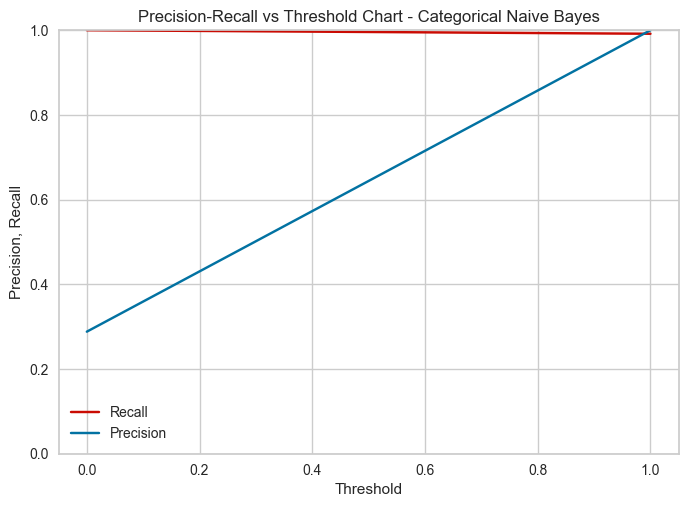

In [35]:
from sklearn.metrics import precision_recall_curve
probs_y = gaussian_NB.predict_proba(tf_matrix_array_cluster)
precision, recall, thresholds = precision_recall_curve(df['is_spam'], probs_y[:, 1])

plt.title("Precision-Recall vs Threshold Chart - Categorical Naive Bayes")
plt.plot(thresholds, recall[: -1], "r", label="Recall")
plt.plot(thresholds, precision[: -1], "b", label="Precision")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0, 1])

(0.0, 1.0)

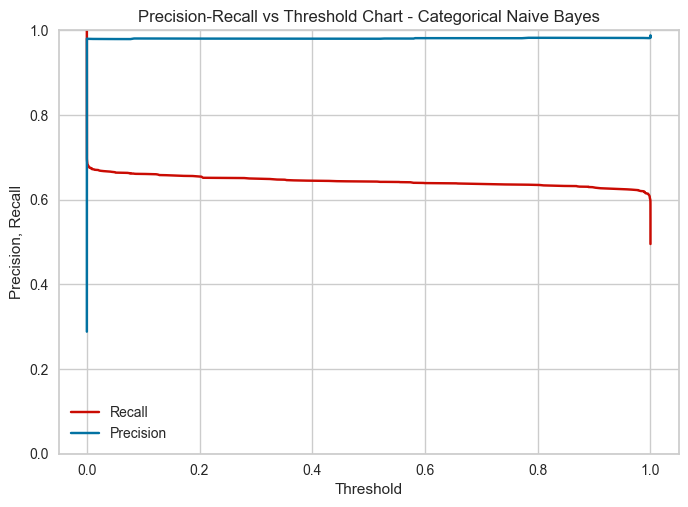

In [36]:
from sklearn.metrics import precision_recall_curve
probs_y = bernoulli_NB.predict_proba(tf_matrix_array_cluster)
precision, recall, thresholds = precision_recall_curve(df['is_spam'], probs_y[:, 1])

plt.title("Precision-Recall vs Threshold Chart - Categorical Naive Bayes")
plt.plot(thresholds, recall[: -1], "r", label="Recall")
plt.plot(thresholds, precision[: -1], "b", label="Precision")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0, 1])

(0.0, 1.0)

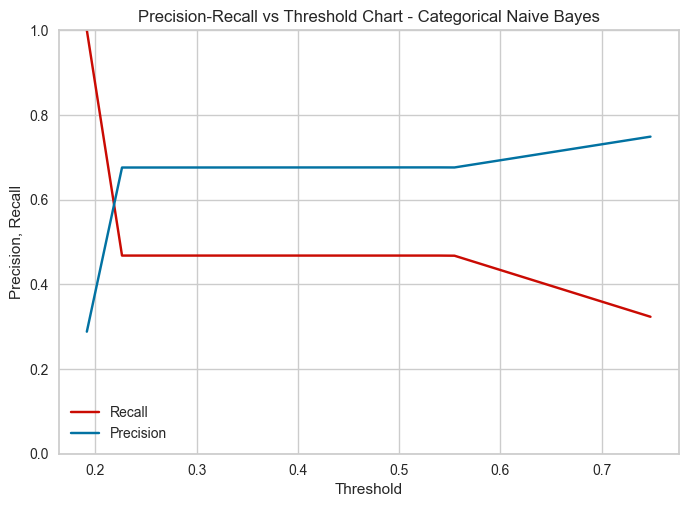

In [37]:
from sklearn.metrics import precision_recall_curve
probs_y = categorical_NB.predict_proba(tf_matrix_array_cluster)
precision, recall, thresholds = precision_recall_curve(df['is_spam'], probs_y[:, 1])

plt.title("Precision-Recall vs Threshold Chart - Categorical Naive Bayes")
plt.plot(thresholds, recall[: -1], "r", label="Recall")
plt.plot(thresholds, precision[: -1], "b", label="Precision")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0, 1])

(0.0, 1.0)

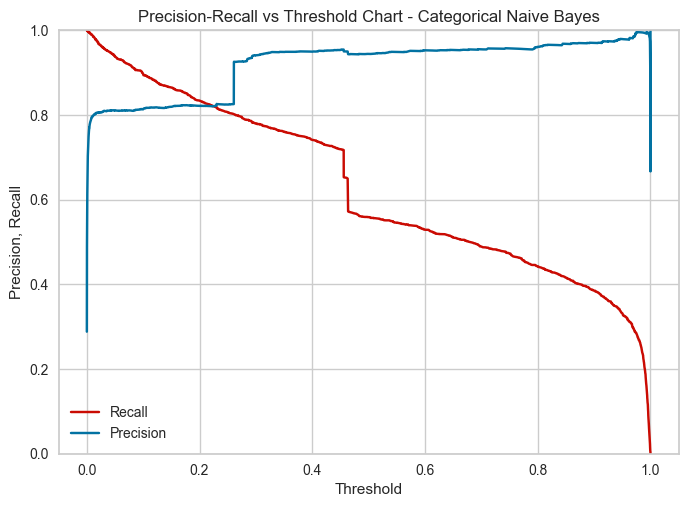

In [38]:
from sklearn.metrics import precision_recall_curve
probs_y = complement_NB.predict_proba(tf_matrix_array_cluster)
precision, recall, thresholds = precision_recall_curve(df['is_spam'], probs_y[:, 1])

plt.title("Precision-Recall vs Threshold Chart - Categorical Naive Bayes")
plt.plot(thresholds, recall[: -1], "r", label="Recall")
plt.plot(thresholds, precision[: -1], "b", label="Precision")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0, 1])

(0.0, 1.0)

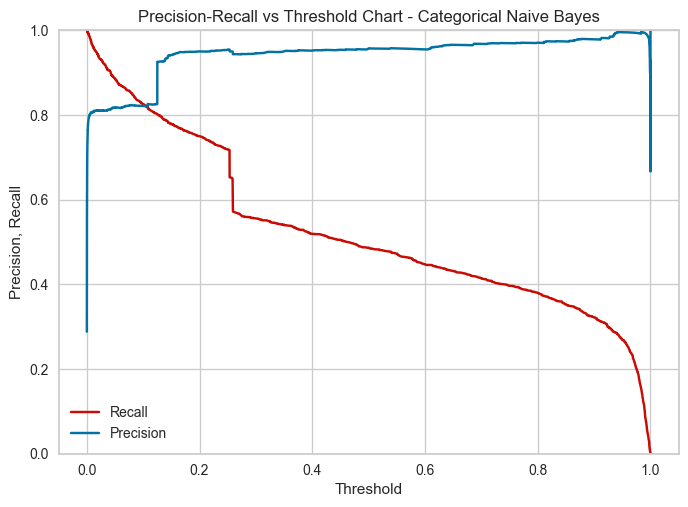

In [39]:
from sklearn.metrics import precision_recall_curve
probs_y = multinomial_NB.predict_proba(tf_matrix_array_cluster)
precision, recall, thresholds = precision_recall_curve(df['is_spam'], probs_y[:, 1])

plt.title("Precision-Recall vs Threshold Chart - Categorical Naive Bayes")
plt.plot(thresholds, recall[: -1], "r", label="Recall")
plt.plot(thresholds, precision[: -1], "b", label="Precision")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0, 1])